# <center>TP Nro 2: Aplicaciones de la DFT 2021 1C </center>
### <center> Universidad Nacional de Tres de Febrero <br>  Ingenieria de Sonido <br><br> Alumno: Franco Rébora </center>
    

En la celda a continuación, se importan las librerias usadas a lo largo del trabajo. En el caso del módulo llamado dsp, se refiere al archivo 'dsp.py' que se encuentra en la misma carpeta del Notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal.windows import windows
from scipy.signal import fftconvolve
from dsp import mediamovildr
from jupyterthemes import jtplot
jtplot.style(grid=True)

---

## <center> DFT Basico </center> 
## <u>Ejercicio 1</u>:
Dada la señal discreta, x(t) de un 1 segundo de duración, compuesta por tres funciones $x1(t)+x2(t)+x3(t)$ que se reescriben a continuación, y muestreada a Fs = 44.1 kHz:

$x_1 (t) = 2$ \
$x_2 (t) = cos(2 \pi f_2 t) e^{- \frac{(t-\mu_2)^2}{2\sigma_2^2}}\;\;\;\;\;\;\;\;f_2 = 10kHz$ $\mu_2 = 0.2s$ $\sigma_2 = 0.05s$ \
$x_3 (t) = sen(2 \pi f_3 t) e^{- \frac{(t-\mu_3)^2}{2\sigma_3^2}}\;\;\;\;\;\;\;\;f_3 = 10.1kHz$ $\mu_3 = 0.7s$ $\sigma_3 = 0.07s$

Graficar la magnitud (en escala lineal y en dB) y la fase de la transformada de Fourier (DFT) de la señal total. Indicar qué representan las componentes no nulas. El eje de frecuencia debe estar en Hz.

## <u>Respuesta</u>: 

### Generacion de la senal x(t):
Se comienza generando la señal $x(t)$ como pide el ejercicio, con una duracion de un segundo y una frecuencia de muestreo de 44100 Hz.

In [2]:
# Duracion y frecuencia de muestreo
time = 1
fs = 44100
vector_t = np.linspace(0,time,time*fs)

# Parametros de cada senal
f2 = 10000
mu2 = 0.2
sigma2 = 0.05

f3 = 10100
mu3 = 0.7
sigma3 = 0.07

exp2 = ((vector_t-mu2)**2)/(2*(sigma2**2))
exp3 = ((vector_t-mu3)**2)/(2*(sigma3**2))

x1 = 2*np.ones_like(vector_t)
x2 = np.cos(2*np.pi*f2*vector_t)*(np.e**(-exp2))
x3 = np.sin(2*np.pi*f3*vector_t)*(np.e**(-exp3))
x = x1+x2+x3

In [3]:
print(len(vector_t))

44100


Luego, utilizando la librería Numpy, se utiliza la función rfft. La FFT es un algoritmo que permite calcular la DFT de forma rapida, siendo su resultado identico al de la DFT. Por lo tanto, se utiliza la FFT a lo largo de este trabajo. <br>
Cabe aclarar que esta función tiene como salida la mitad derecha del resultado de la fft, es decir, solo las frecuencias positivas. Ya que para el análisis que se busca, no son necesarias las frecuencias negativas y no tienen representación práctica en la vida real. 

In [4]:
# Implementacion de Scipy de la FFT
fft_x = np.fft.rfft(x)
freqs_x = np.fft.rfftfreq(time*fs, 1/fs)

# En dBFS
valueDBFS = 20*np.log10(abs(fft_x)/max(abs(fft_x)))

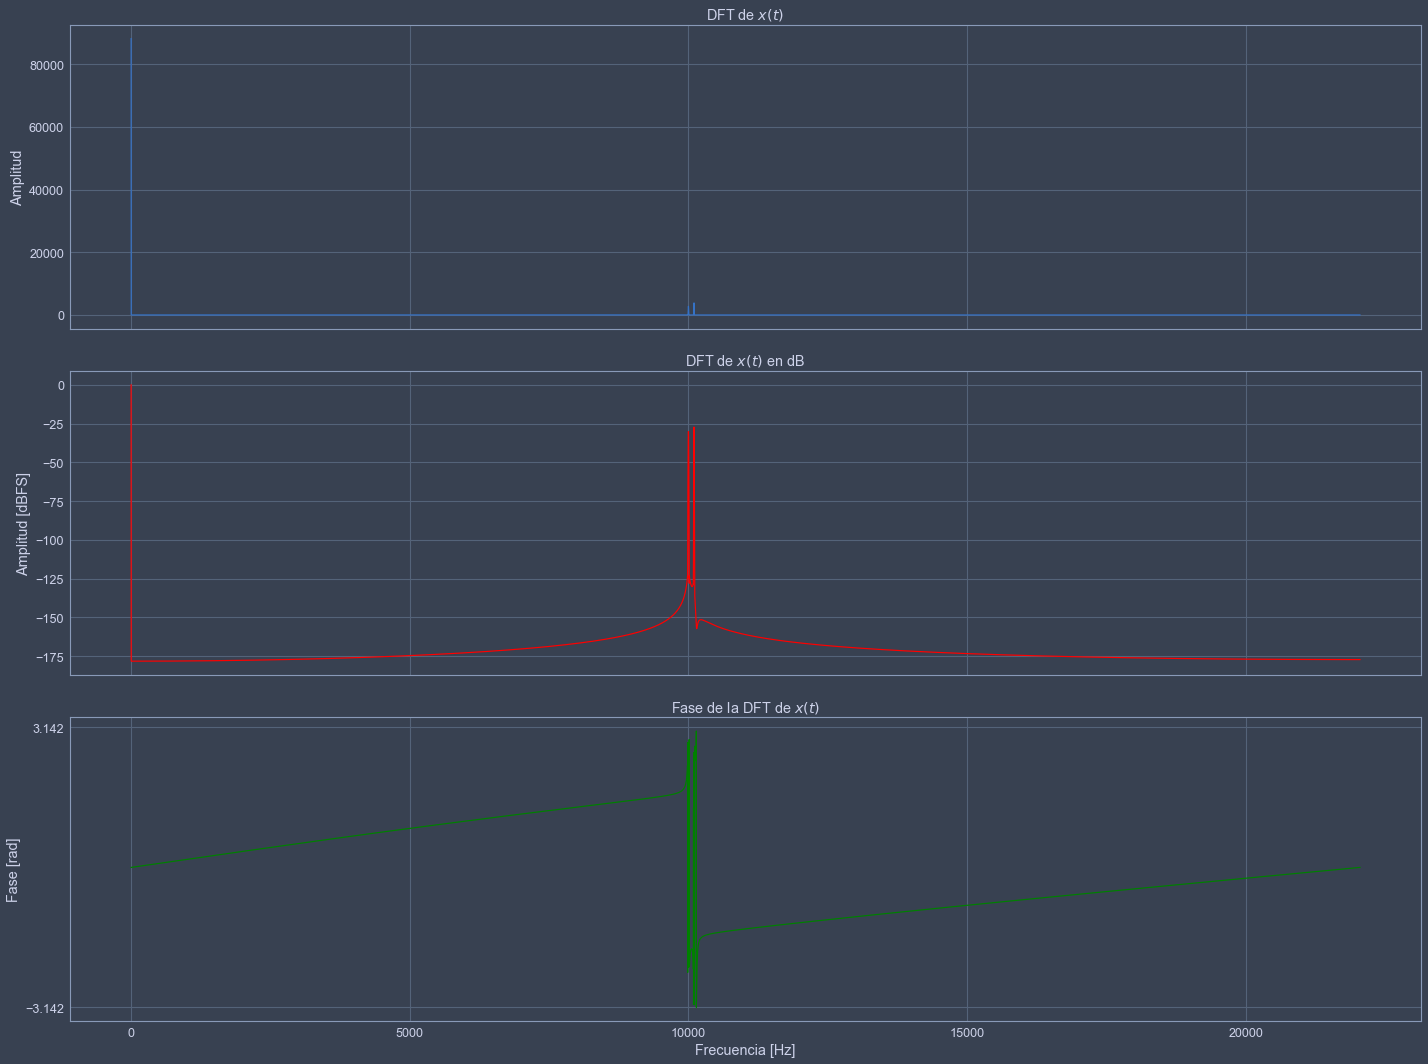

In [5]:
# Plot de la DFT
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(3, 1, sharex=True, figsize=[20, 15])
axs[0].plot(freqs_x, np.abs(fft_x))
axs[0].set_title('DFT de $x(t)$')
axs[1].plot(freqs_x, valueDBFS, color='red')
axs[1].set_title('DFT de $x(t)$ en dB')
axs[2].plot(freqs_x, np.angle(fft_x), color='green')
axs[2].set_title('Fase de la DFT de $x(t)$')

fig.tight_layout()

axs.flat[0].set(ylabel='Amplitud')
axs.flat[1].set(ylabel='Amplitud [dBFS]')
axs.flat[2].set(ylabel='Fase [rad]', xlabel='Frecuencia [Hz]', yticks=(-np.pi,np.pi))

# for ax in axs.flat:
#     ax.grid()
    
plt.show()

### Conclusión:
La componente en cero representa la señal continua x1 de frecuencia 0 Hz (por ser constante). <br>
Por otro lado, en la DFT de escala lineal, se puede apreciar las componentes de frecuencia 10 kHz y 10.1 kHz de las señales x2 y x3 respectivamente. <br>
Sin embargo, en la DFT de escala en dB se puede ver fácilmente el leaking generado en la transformada, que se encuentra cercano a las frecuencias de 10 y 10.1 kHz y tiene forma de lóbulo. Una forma de interpretar ese lóbulo es como si estuvieramos convolucionando la respuesta en frecuencia de una ventana cuadrada (similar a una funcion sinc con un lóbulo centrado en cero) con dos deltas de kronecker en 10 y 10.1 kHz respectivamente.


---

## <center> Uso de ventanas
## <u>Ejercicio 2</u>:
La señal del inciso 1 se modificará cambiando la frecuencia de $x_3(t)$, siendo el nuevo valor $f_3 = 10008.37 Hz$, y además se le sumará una componente de ruido aleatorio (normal) $r(t)$, quedando la señal total $x_1(t)+x_2(t)+x_3(t)+ r(t)$, también de 1 segundo de duración y muestreada a Fs = 44.1 kHz:

$x_1 (t) = 2$ \
$x_2 (t) = cos(2 \pi f_2 t) e^{- \frac{(t-\mu_2)^2}{2\sigma_2^2}}\;\;\;\;\;\;\;\;f_2 = 10kHz$&emsp;$\mu_2 = 0.2s$&emsp;$\sigma_2 = 0.05s$ \
$x_3 (t) = sen(2 \pi f_3 t) e^{- \frac{(t-\mu_3)^2}{2\sigma_3^2}}\;\;\;\;\;\;\;\;f_3 = 10008.37Hz$&emsp;$\mu_3 = 0.7s$&emsp;$\sigma_3 = 0.07s$ 

$r(t) =$ ruido aleatorio normal

Graficar la magnitud transformada de Fourier (DFT) de la señal total utilizando tres ventanas diferentes: Rectangular, Hann y Blackman. La señal debe multiplicarse por la ventana antes del cálculo de la DFT. Además, graficar en escala de dB la DFT de cada una de las ventanas, y comparar el ancho del lóbulo principal y la atenuación. Determinar cuál ventana elegirían para diferenciar las componentes de frecuencia (10000 y 10008.37 Hz) y por qué. ¿Cambiarían algún
otro parámetro en el cálculo de la DFT para mejorar la resolución?

## <u>Respuesta</u>: 

### Generación de señal y ventanas:

In [6]:
# Generacion de la senal x3 para este ejercicio
f3_ej2 = 10008.37
x3_ej2 = np.sin(2*np.pi*f3_ej2*vector_t)*(np.e**(-exp3))

# Generacion de ruido
noise = 0.01*np.random.normal(0,1,fs*time)

x_ej2 = x1 + x2 + x3_ej2 + noise

In [7]:
# Generacion de ventanas
ej2_window_len = 44100
ej2_rectangular = np.ones(ej2_window_len)
ej2_hann = windows.hann(ej2_window_len)
ej2_blackman = windows.blackman(ej2_window_len)

### Plot de la magnitud  de la transformada de Fourier (DFT) utilizando las tres ventanas:
Se varía la longitud de la fft para lograr un gráfico más suave en términos visuales. Cabe aclarar que la resolución en frecuencia no depende de este parámetro.

In [8]:
# Calculo de DFT de la senal ventaneada
fft_length2 = fs + 10000

ej2_dft_xrectangular = np.fft.rfft(x_ej2*ej2_rectangular,fft_length2)
ej2_dft_xhann = np.fft.rfft(x_ej2*ej2_hann,fft_length2)
ej2_dft_xblackman = np.fft.rfft(x_ej2*ej2_blackman,fft_length2)

ej2_dft_xrectangular = ej2_dft_xrectangular/max(abs(ej2_dft_xrectangular[5:]))
ej2_dft_xhann = ej2_dft_xhann/max(abs(ej2_dft_xhann[5:]))
ej2_dft_xblackman = ej2_dft_xblackman/max(abs(ej2_dft_xblackman[5:]))

ej2_freqs = np.fft.rfftfreq(fft_length2, 1/fs)

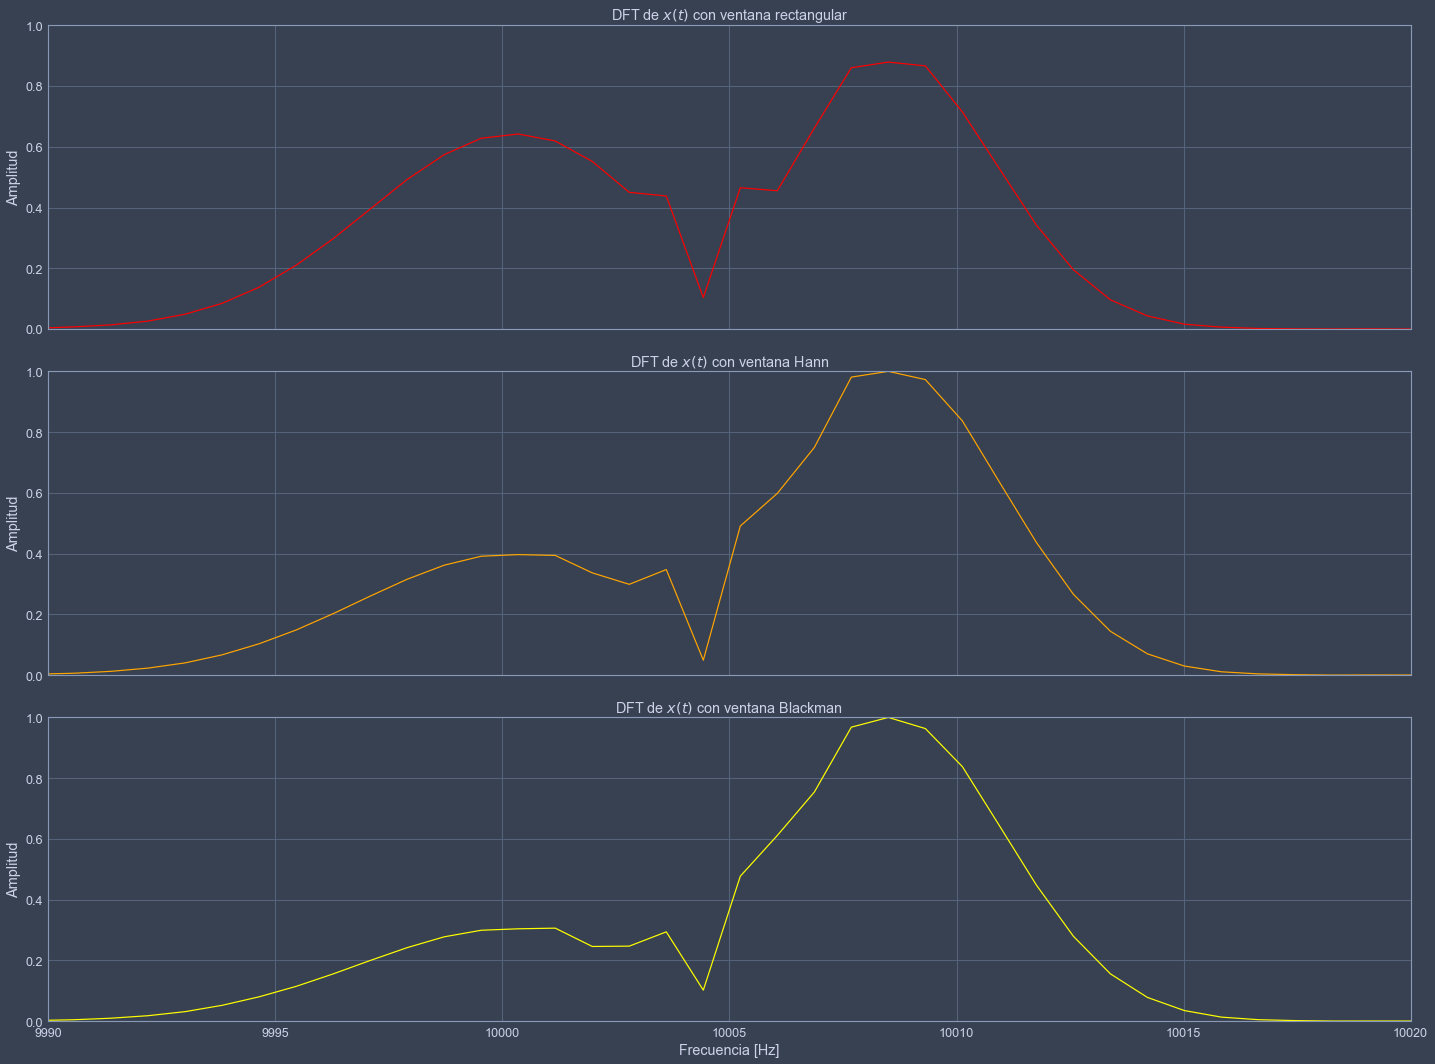

In [9]:
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(3, 1, sharex=True, figsize=[20, 15])
axs[0].plot(ej2_freqs, np.abs(ej2_dft_xrectangular), color='red')
axs[0].set_title('DFT de $x(t)$ con ventana rectangular')
axs[1].plot(ej2_freqs, np.abs(ej2_dft_xhann), color='orange')
axs[1].set_title('DFT de $x(t)$ con ventana Hann')
axs[2].plot(ej2_freqs, np.abs(ej2_dft_xblackman), color='yellow')
axs[2].set_title('DFT de $x(t)$ con ventana Blackman')

fig.tight_layout()

axs.flat[0].set(ylabel='Amplitud')
axs.flat[1].set(ylabel='Amplitud')
axs.flat[2].set(ylabel='Amplitud', xlabel='Frecuencia [Hz]')

for ax in axs.flat:
    ax.set_xlim(9990,10020)
    ax.set_ylim(0,1)
#     ax.grid()
plt.show()

### DFT de las ventanas:

In [10]:
# Calculo de DFT de la senal ventaneada y longitud de la FFT (para cambiar el grafico)
fft_length = 44100 + 1000
dft_rectangular = np.fft.rfft(ej2_rectangular,fft_length)
dft_hann = np.fft.rfft(ej2_hann,fft_length)
dft_blackman = np.fft.rfft(ej2_blackman,fft_length)

# Convertir a dB:
dft_rectangular = 20 * np.log10(np.maximum(np.abs(dft_rectangular), 1e-10))
dft_hann = 20 * np.log10(np.maximum(np.abs(dft_hann), 1e-10))
dft_blackman = 20 * np.log10(np.maximum(np.abs(dft_blackman), 1e-10))

# Vector de Frecuencias
freqs = fftfreq(time*fft_length, 1/fft_length)

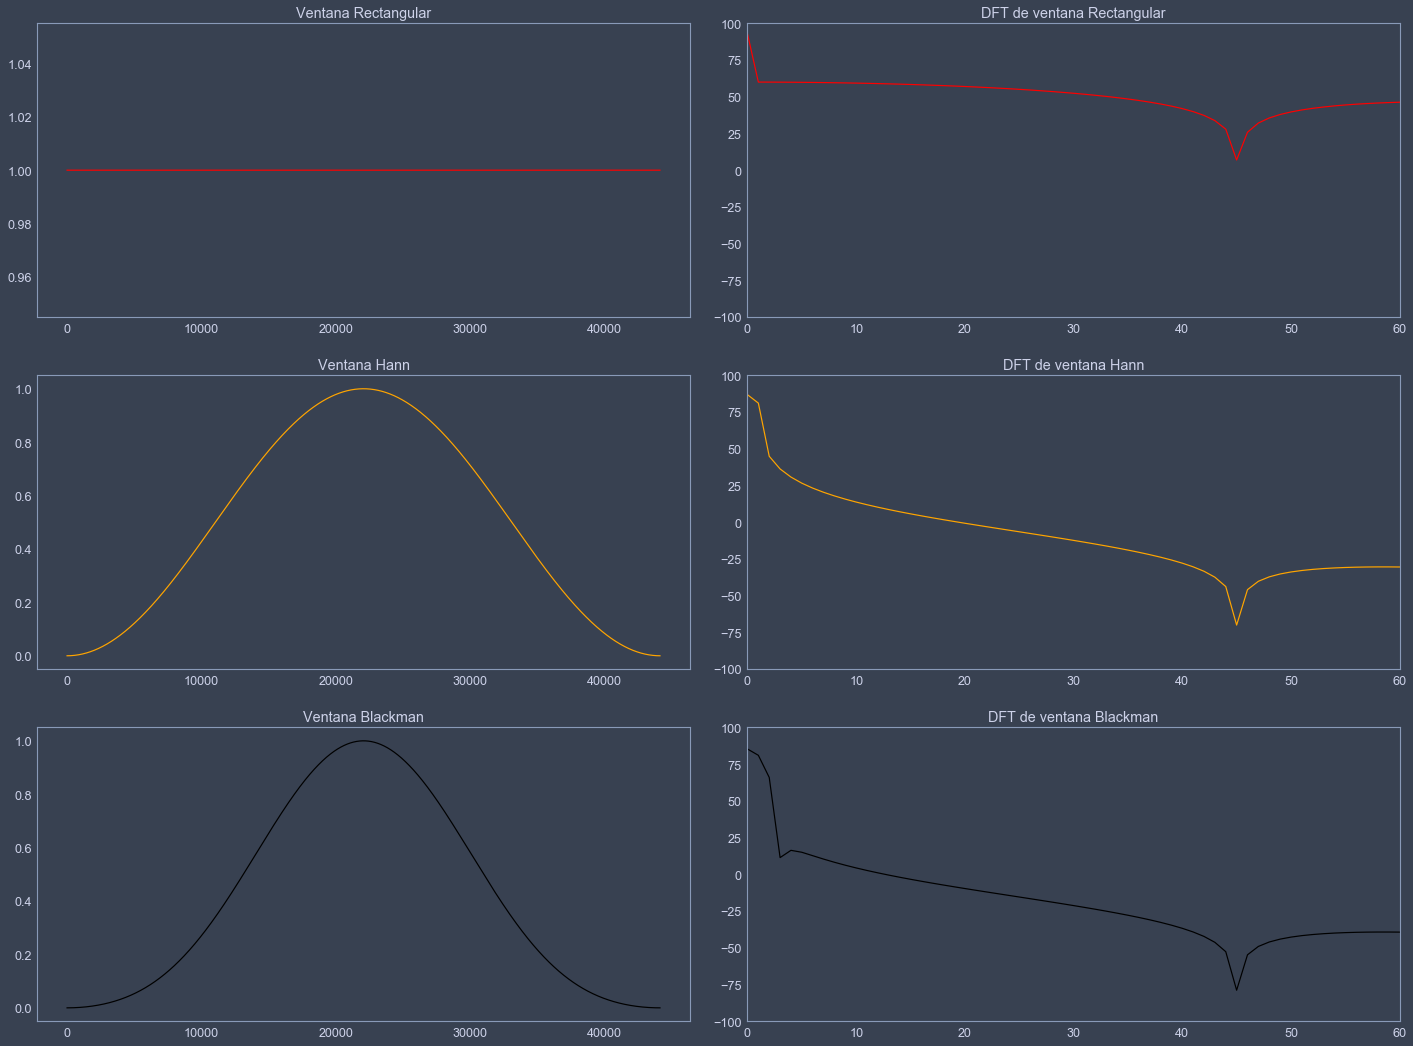

In [11]:
fig, ax = plt.subplots(3,2, figsize=[20,15])
ax[0,0].plot(ej2_rectangular, color='red')
ax[0,1].plot(dft_rectangular, color='red')
ax[1,0].plot(ej2_hann, color='orange')
ax[1,1].plot(dft_hann, color='orange')
ax[2,0].plot(ej2_blackman, color='black')
ax[2,1].plot(dft_blackman, color='black')

ax[0,0].set_title('Ventana Rectangular')
ax[0,1].set_title('DFT de ventana Rectangular')
ax[1,0].set_title('Ventana Hann')
ax[1,1].set_title('DFT de ventana Hann')
ax[2,0].set_title('Ventana Blackman')
ax[2,1].set_title('DFT de ventana Blackman')

fig.tight_layout()
[ax[i,0].grid() for i in range(3)]
[ax[i,1].grid() for i in range(3)]

for i in range(3):
    ax[i,1].set_xlim(0,60)    
    ax[i,1].set_ylim(-100,100)

### Conclusión:
En este caso, la mejor ventana para diferenciar ambas señales es la ventana cuadrada. 
Esto se debe a que, al tener el lóbulo principal menor que las demás, si se analiza la multiplicación entre la ventana y la señal, el ancho del lóbulo en la frecuencia sera más chico.

---

## <center> Interpolación cuadrática
### <u>Ejercicio 3</u>:
Ahora, nos quedaremos con la componente $x_3(t)$ del inciso anterior para implementar una interpolación que mejore la resolución en frecuencia del máximo de la DFT. La señal será entonces de 1 segundo de duración y muestreada a Fs = 44.1 kHz:<br><br>

<center>$x_3 (t) = sen(2 \pi f_3 t) e^{- \frac{(t-\mu_3)^2}{2\sigma_3^2}}\;\;\;\;\;\;\;\;f_3 = 10008.37Hz$&emsp;$\mu_3 = 0.7s$&emsp;$\sigma_3 = 0.07s$ 


Se deberá graficar la magnitud, expresada en dB, de la DFT de la señal $x_3(t$) y se determinará la frecuencia a la que se detecta el máximo de la magnitud, verificándose que no es la frecuencia exacta. En casos como este, en donde la resolución no es suficiente para discriminar el valor de una componente de frecuencia, se puede mejorar la determinación de la posición mediante técnicas de interpolación. Una de las más simples, pero efectivas, es utilizar la interpolación cuadrática que se calcula con la siguiente ecuación: <br><br>

<center> $\hat{n}_{max} = n_{max} + \frac{\alpha - \gamma}{2(\alpha - 2\beta + \gamma)}$

En donde,\
nmax : posición encontrada del punto máximo.\
$\beta = g[nmax]$ valor absoluto de la magnitud en dB en la posición máxima nmax del pico. \
$\alpha = g[nmax-1]$ valor absoluto de la magnitud en dB en la posición anterior al máximo del pico. \
$\gamma = g[nmax+1]$ valor absoluto de la magnitud en dB en la posición posterior al máximo del pico.


**Nota:** esta ecuación está definida para un intervalo unitario (muestreo o resolución). Si dicho valor no es 1, debe multiplicarse el valor correspondiente al segundo sumando de la ecuación.

## <u>Respuesta</u>: 

In [12]:
x_ej3 = x3_ej2

ej3_dft_x = np.fft.rfft(x_ej3)
ej3_dft_x = 20 * np.log10(np.maximum(np.abs(ej3_dft_x), 1e-10))

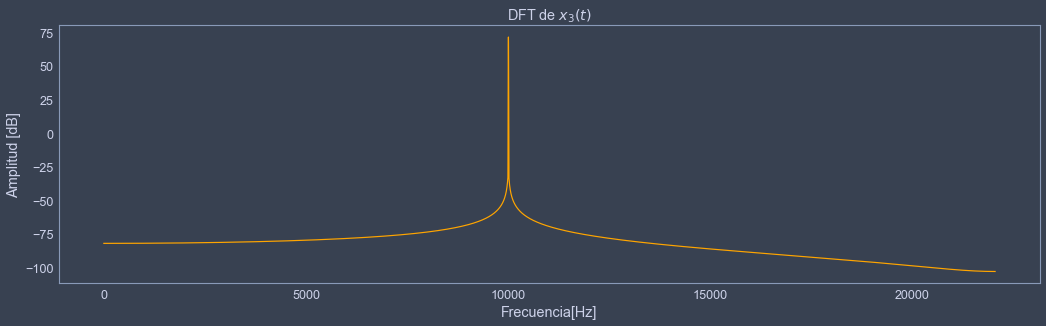

In [13]:
# Plot
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(1, 1, figsize=[15, 5])
axs.plot(ej3_dft_x, color='orange')
axs.set_title('DFT de $x_3(t)$')
axs.set(xlabel='Frecuencia[Hz]', ylabel='Amplitud [dB]')
axs.grid()

fig.tight_layout()
plt.show()

In [14]:
# Busca la frecuencia maxima y defino los parametro beta, alfa y gamma.
nmax = np.argmax(ej3_dft_x)
beta = ej3_dft_x[nmax]
alfa = ej3_dft_x[nmax-1]
gamma = ej3_dft_x[nmax+1]

# Ecuacion de la interpolacion
nmax_aprox = nmax + ((alfa-gamma)/(2*(alfa - 2*beta + gamma)))
print('El resultado de nmax aproximado es de: ', round(nmax_aprox,3), 'Hz')

El resultado de nmax aproximado es de:  10008.597 Hz


### Conclusión:
El resultado muestra que la interpolación acerca el valor desde el entero 10009 Hz hasta su valor original. Se puede ver que la aproximación no es perfecta ya que no tiene los mismos valores decimales.

---

## <center>Filtro Media Móvil</center>
### <u>Ejercicio 4</u>:
A partir de la respuesta al impulso del filtro de media móvil, dada en el inciso 6 del TP1, determinar el valor particular de M para que el filtro deje pasar la componente de 10 kHz de la señal del punto 1, atenuada no más de -3 dB. Graficar la magnitud de la respuesta en frecuencia del filtro y de la señal filtrada.

## <u>Respuesta</u>: 

Se genera la ventana rectangular con tres longitudes M distintas para mostrar la diferencia de respuesta en frecuencia.<br>
A modo ilustrativo, se puede cambiar los valores de M dentro de la siguiente celda de código.

In [15]:
# Generacion de la ventana y su DFT
ej4_M = 2
ej4_rectangular = np.ones(ej4_M)/(ej4_M)
ej4_dft_rectangular = np.fft.rfft(ej4_rectangular,fs)
ej4_dft_rectangular = 20 * np.log10(np.maximum(np.abs(ej4_dft_rectangular), 1e-10))

ej4_M1 = 7
ej4_rectangular1 = np.ones(ej4_M1)/(ej4_M1)
ej4_dft_rectangular1 = np.fft.rfft(ej4_rectangular1,fs)
ej4_dft_rectangular1 = 20 * np.log10(np.maximum(np.abs(ej4_dft_rectangular1), 1e-10))

ej4_M2 = 11
ej4_rectangular2 = np.ones(ej4_M2)/(ej4_M2)
ej4_dft_rectangular2 = np.fft.rfft(ej4_rectangular2,fs)
ej4_dft_rectangular2 = 20 * np.log10(np.maximum(np.abs(ej4_dft_rectangular2), 1e-10))

# Generacion de la senal y su DFT
ej4_dft_x = fftconvolve(x, ej4_rectangular, mode='valid')
ej4_dft_x1 = fftconvolve(x, ej4_rectangular1, mode='valid')
ej4_dft_x2 = fftconvolve(x, ej4_rectangular2, mode='valid')

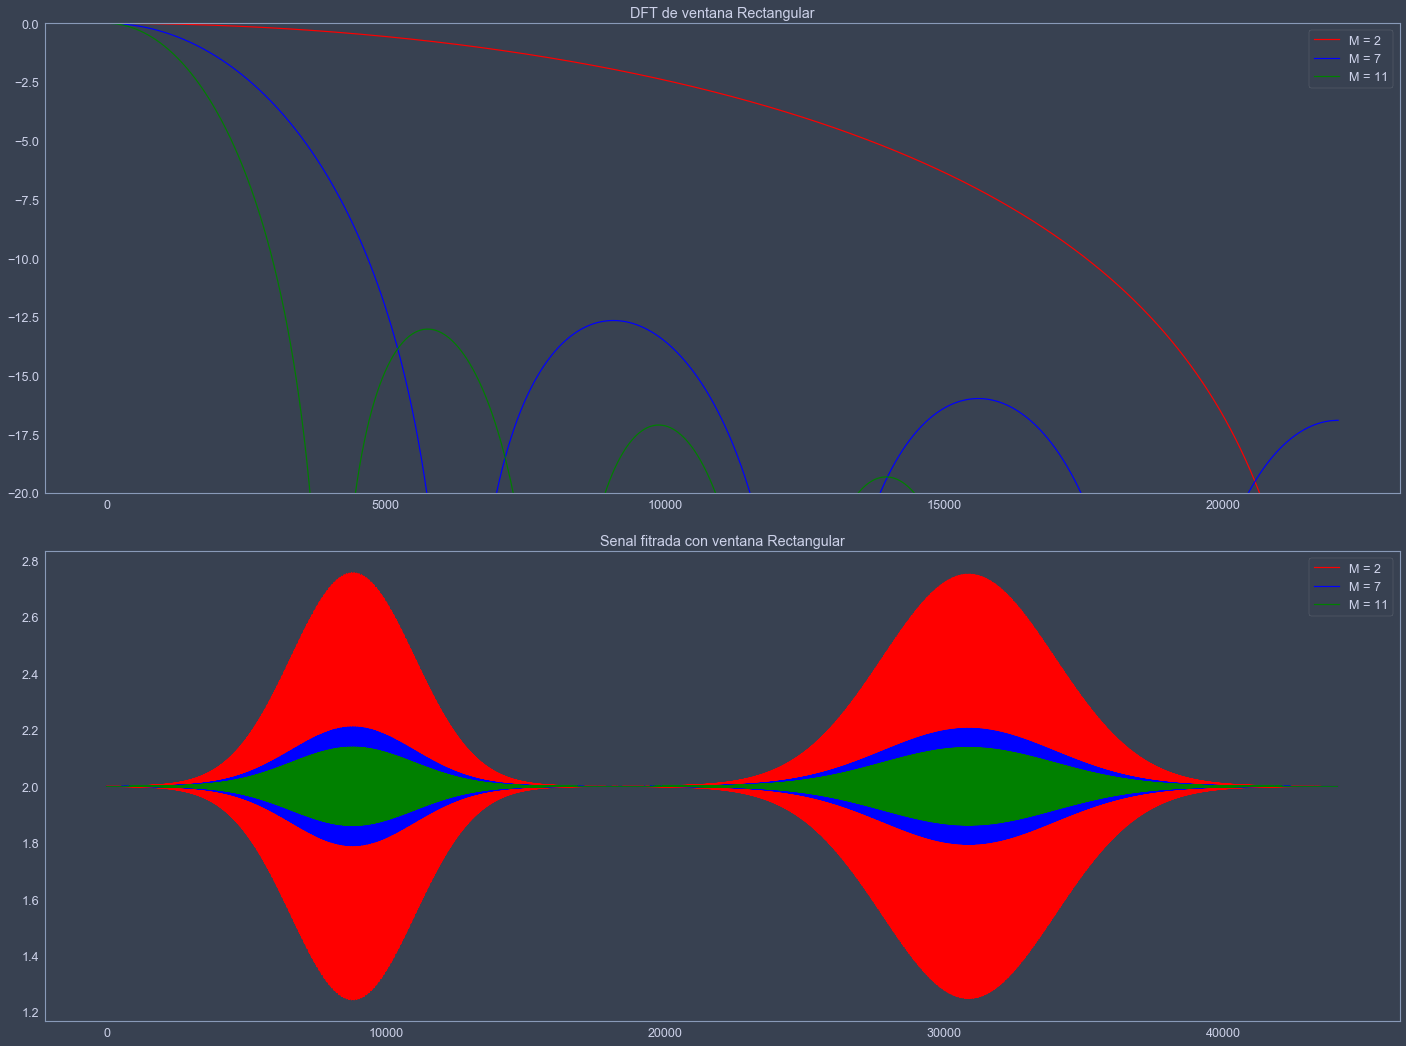

In [16]:
# Plot
fig, ax = plt.subplots(2,1, figsize=[20,15])
ax[0].plot(ej4_dft_rectangular, color='red', label=('M = '+str(ej4_M)))
ax[0].plot(ej4_dft_rectangular1, color='blue', label=('M = '+str(ej4_M1)))
ax[0].plot(ej4_dft_rectangular2, color='green', label=('M = '+str(ej4_M2)))
ax[1].plot(ej4_dft_x, color='red', label=('M = '+str(ej4_M)))
ax[1].plot(ej4_dft_x1, color='blue', label=('M = '+str(ej4_M1)))
ax[1].plot(ej4_dft_x2, color='green', label=('M = '+str(ej4_M2)))

ax[0].set_title('DFT de ventana Rectangular')
ax[0].set_ylim(-20,0)
ax[0].legend()
ax[1].set_title('Senal fitrada con ventana Rectangular')
ax[1].legend()
[ax[i].grid() for i in range(2)]


fig.tight_layout()
plt.show()

### Conclusión:
A partir de ambos gráficos, se puede analizar la atenuación generada en la señal viendo la respuesta en frecuencia de cada ventana. En el caso de $M=2$, se puede verificar una atenuación aproximada de $2.5$ dB desde su respuesta en frecuencia, lo cual cumple con lo que especifica la consigna. Para contrastar este resultado, se puede verificar también que al aumentar el tamaño de la ventana, se reduce el ancho del lóbulo principal de la respuesta en frecuencia, por lo cual la frecuencia de $10$ kHz queda mucho más atenuada con $M=7$ y $M=11$.

---

## <center>Convolución mediante DFT</center>
### <u>Ejercicio 5</u>:

Calcular la convolución lineal del punto 7 del TP1, pero esta vez utilizando el algoritmo de la DFT. Determinar el largo que deben tener las señales a convolucionar para que el resultado de utilizar una convolución circular vía DFT sea equivalente a la convolución lineal.

Para rearmar la senal utilizada en el punto 7 del TP1, se utiliza $x_1$ y $x_2$ de este TP (ya que son las mismas) y se crea $x_3$ para agregarla.

In [17]:
# Senal del ejercicio 7 del TP1
ej5_f3 = 500
ej5_u3 = 0.7
ej5_sigma3 = 0.07
ej5_exp3 = ((vector_t-ej5_u3)**2)/(2*(ej5_sigma3**2))

ej5_x3 = np.sin(2*np.pi*f3*vector_t)*(np.e**(-exp3))
ej5_x = x1+x2+ej5_x3

# Generacion de Ventana rectangular de largo M
ej5_M = 10
ej5_rectangular = np.ones(ej5_M)/ej5_M

El largo que debe tener la senal para ser una convolucion lineal esta determinado por el largo de ambas señales.
En este caso, llamaremos L al largo de la senal x(t) y M al largo de la ventana.
Para que este algoritmo se comporte como una convolucion lineal, se debe cumplir que:<br><br> 

<center>$N = M + L -1$</center>

Siendo N la longitud de la convolucion. A continuacion, se realizaran los calculos con el agregado de ceros.

Por otro lado, la convolucion por DFT es parte de las propiedades dadas por la transformada de Fourier, quedando de esta forma:<br><br>

<center>$\mathscr{F}\{x(t)*h(t)\} = X[n]H[n]$</center>


In [18]:

# Completo x[n] y h[n] con ceros hasta llegar a N=M+L-1.
N = ej5_M + len(ej5_x) - 1
ej5_x = np.pad(ej5_x, (0, int(N-len(ej5_x))))
ej5_rectangular = np.pad(ej5_rectangular, (0, int(N-len(ej5_rectangular))))

# Calculo la DFT de cada senal
ej5_dft_rectangular = np.fft.fft(ej5_rectangular)
ej5_dft_x = np.fft.fft(ej5_x)

# Multiplicar X[k] con H[k] para obtener Y[k]
ej5_dft_conv = ej5_dft_x*ej5_dft_rectangular

# Realizo la IDFT para obtener y[n]
ej5_conv = np.fft.ifft(ej5_dft_conv)

???????????????????????????????????????????????????????????

Y si quiero mostrar la circular?????????? Porque me pide determinar el largo y yo lo estoy poniendo como valor teorico.

?????????????????????????????????????????????

PORQUE ME DA VALORES COMPLEJOS?

COMO HAGO PARA GRAFICARLA BIEN COMO SI ESTUVIERA EN MODO VALID

C:\Users\user\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


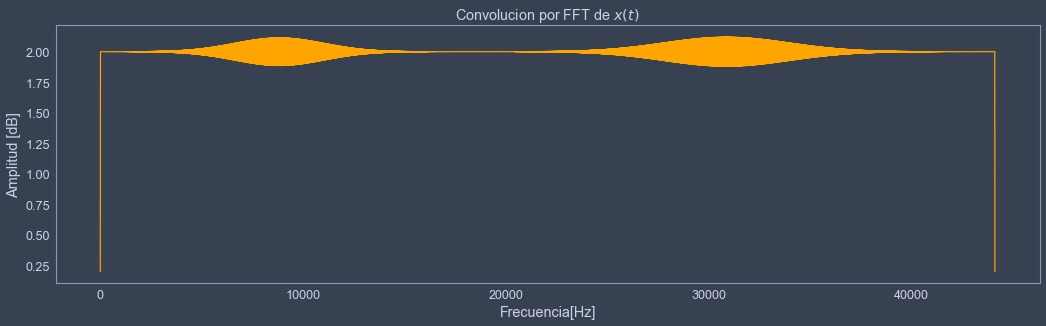

In [19]:
# Plot
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(1, 1, figsize=[15, 5])
axs.plot(ej5_conv, color='orange')
axs.set_title('Convolucion por FFT de $x(t)$')
axs.set(xlabel='Frecuencia[Hz]', ylabel='Amplitud [dB]')
axs.grid()

fig.tight_layout()
plt.show()

---

## <center> Derivación en frecuencia </center>
### <u>Ejercicio 6</u>:
Los métodos numéricos para resolver ecuaciones diferenciales deben poder calcular las derivadas mediante algún método aproximado. Uno de los más métodos más conocidos es el de diferencias finitas, que si bien es simple, no siempre tiene la precisión deseada. Otro método, es el de la diferenciación en frecuencia que hace uso de las propiedades de la transformada de Fourier. En este punto deberán tomar la señal $x_2(t)$ de un 1 segundo de duración y muestreada a $Fs=44.1 kHz$:

$x_2 (t) = cos(2 \pi f_2 t) e^{- \frac{(t-\mu_2)^2}{2\sigma_2^2}}\;\;\;\;\;\;\;\;f_2 = 10kHz$&emsp;$\mu_2 = 0.2s$&emsp;$\sigma_2 = 0.05s$ 

y calcular la derivada analítica, la primera diferencia hacia adelante (forward) y la derivada por el
método de la transformada de Fourier. Graficar los resultados y compara la aproximación de la
derivada por los dos métodos numéricos. Se puede seguir la referencia [4] para la implementación.


In [20]:
# Defino la senal
ej6_x = np.copy(x2)

# 1er metodo: Derivada analitica
a = 2*np.pi*f2
x = vector_t
b = mu2
c = sigma2
dx_dt = (-a*np.sin(a*x)*(np.e**-(((x-b)**2)/c)) - 
         2 * (x-b) * np.cos(a*x) * (np.e**-(((x-b)**2)/c)) / c)

# 2do metodo: diferencia hacia adelante
L = len(ej6_x)
n = fs
for i in range(len(ej6_x)):
    dx_FD = ej6_x[i]-ej6_x[i-1] / (L/n)

# 3er metodo: metodo por la DFT
ej6_fft_len = fs
fhat = np.fft.fft(ej6_x)
kappa = (2*np.pi/L)*np.arange(-fs/2,(fs/2))
kappa = np.fft.fftshift(kappa)
dfhat = (i * kappa * fhat)
dx_FFt = np.real(np.fft.ifft(dfhat))

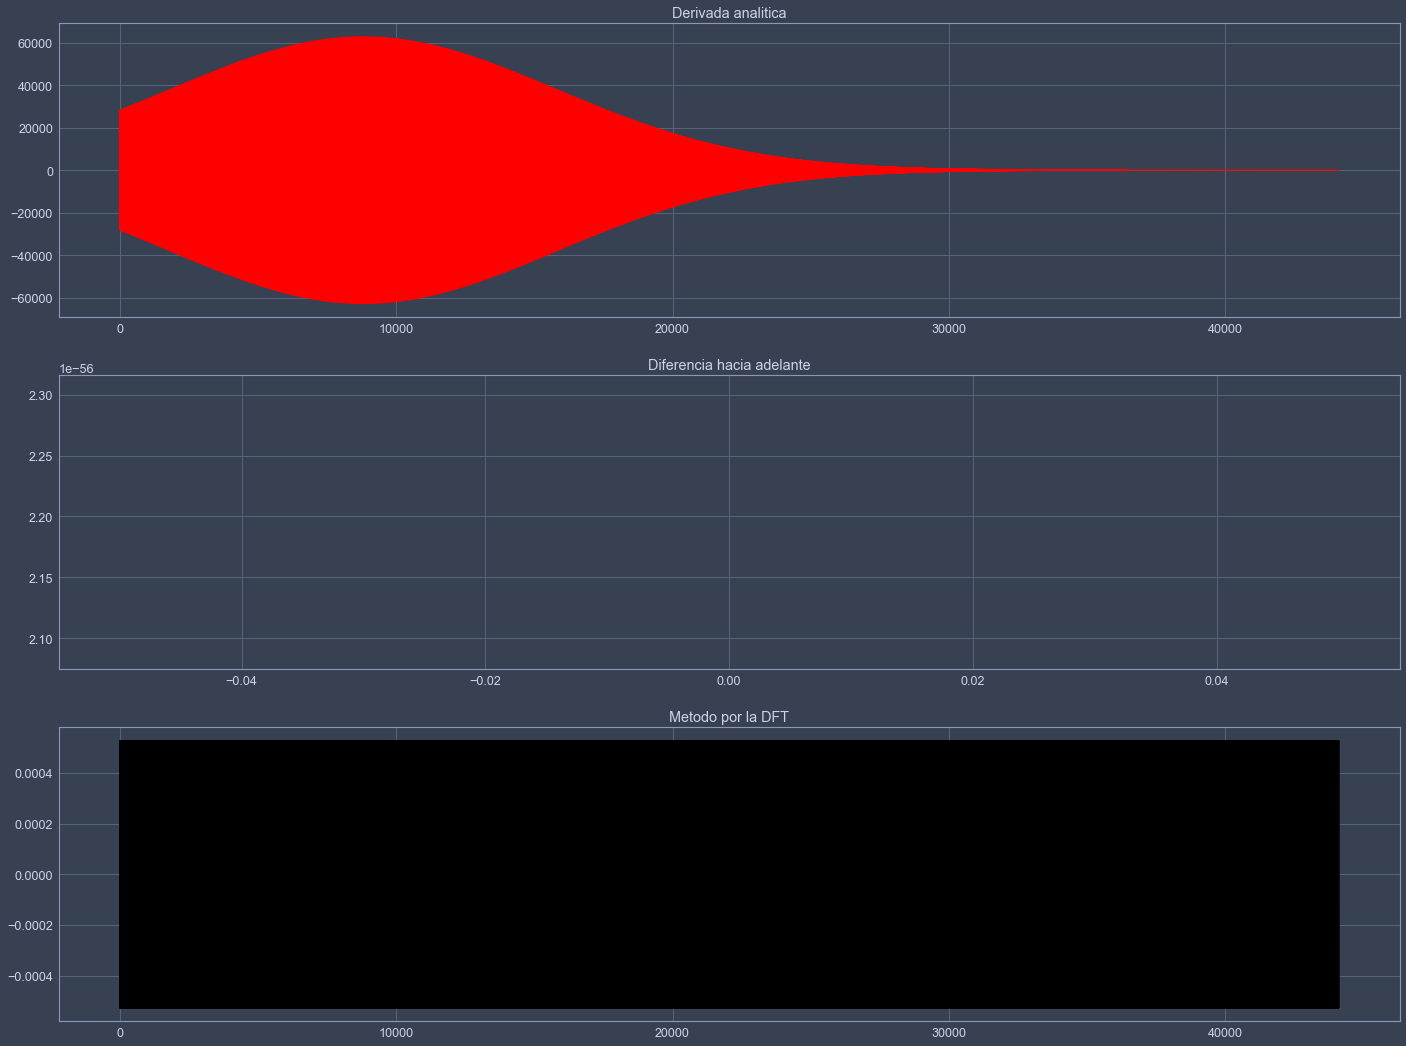

In [23]:
fig, ax = plt.subplots(3, 1, figsize=[20,15])
ax[0].plot(dx_dt, color='red')
ax[1].plot(dx_FD, color='orange')
ax[2].plot(dx_FFt, color='black')

ax[0].set_title('Derivada analitica')
ax[1].set_title('Diferencia hacia adelante')
ax[2].set_title('Metodo por la DFT')

fig.tight_layout()
# [ax[i,0].grid() for i in range(3)]
# [ax[i,1].grid() for i in range(3)]

# for i in range(3):
#     ax[i,1].set_xlim(0,60)    
#     ax[i,1].set_ylim(-100,100)

---

## Transformada en tiempo corto de Fourier (STFT) - Espectrograma
### <u>Ejercicio 7</u>:
A la señal del inciso 1 de este TP calcular y graficar la magnitud en dB y la fase de su STFT. Realizar tres gráficos cambiando el tipo de ventana y el largo del cálculo de la FFT. Determinar alguna combinación de las tres anteriores que sea (parezca) mejor para representar a la señal en estudio.